In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

### Generate synthetic data

In [2]:
from synthetics import generate_single_task_unipolar, gaussian_bags_of_words, vocab1k

N = 10000
M = 30
K = 2 # binary problem (class labels: {1,2})
NUM_SPLITS = 3

Ds = [] # data
Xs = [] # features
Ls = [] # noisy labels
Ys = [] # true labels
for _ in range(NUM_SPLITS):
    L, Y, _ = generate_single_task_unipolar(
        N, M, k=K, alpha_range=[0.6, 0.9], beta_range=[0.1, 0.2], 
        class_balance=[0.25, 0.75], seed=1)
    
    X, D = gaussian_bags_of_words(Y, vocab1k)
    
    Ls.append(L)
    Ys.append(Y)
    Ds.append(D)
    Xs.append(X)

### Apply LabelModel

Overwriting seed=None to seed=1
Overwriting n_epochs=100 to n_epochs=500
Overwriting lr=0.01 to lr=0.001
Reaffirming l2=0.0
Overwriting print_at=10 to print_at=100
Reaffirming show_plots=True
[Epoch 0] Loss: 309.458144
[Epoch 100] Loss: 0.104923
[Epoch 200] Loss: 0.010308
[Epoch 300] Loss: 0.004366
[Epoch 400] Loss: 0.003250
[Epoch 499] Loss: 0.002682
Finished Training


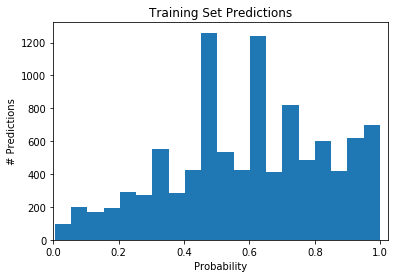

Confusion Matrix (Dev)
        y=1    y=2   
 l=1   1376   5364   
 l=2   1155   2105   


In [3]:
from metal.label_model import LabelModel

lm = LabelModel(seed=1)

lm.train(Ls[0], L_dev=Ls[1], Y_dev=Ys[1], 
         n_epochs=500, lr=0.001, l2=0, print_at=100, show_plots=True)

In [4]:
Y_p = lm.score(Ls[1], Ys[1], metric='f1')

F1: 0.299


In [5]:
Y_p = lm.predict(Ls[0])

### Random Search

In [6]:
search_space = {
    'print_at': 200,
    'n_epochs': 1000, # a single constant value
    'l2': [0, 0.1, 0.01], # a list of discrete values
    'lr': {'range': [0.01, 0.0001], 'scale': 'log'}, # a range and scale to interpolate by
}

In [7]:
from metal.tuner import ModelTuner

tuner = ModelTuner(LabelModel)
init_args = []
train_args = [Ls[0]]
best_model, best_config = tuner.search(init_args, train_args, Ls[1], Ys[1], 
                                  search_space, max_search=5, metric='f1')

[1] Testing {'l2': 0.1, 'lr': 0.0003236965357034848}
Overwriting show_plots=True to show_plots=False
[Epoch 0] Loss: 348.308474
[Epoch 200] Loss: 0.814816
[Epoch 400] Loss: 0.617487
[Epoch 600] Loss: 0.591114
[Epoch 800] Loss: 0.582902
[Epoch 999] Loss: 0.578790
Finished Training
F1: 0.414
[2] Testing {'l2': 0.01, 'lr': 0.004884765313390349}
Reaffirming show_plots=False
[Epoch 0] Loss: 310.162698
[Epoch 200] Loss: 0.064146
[Epoch 400] Loss: 0.063409
[Epoch 600] Loss: 0.063236
[Epoch 800] Loss: 0.063131
[Epoch 999] Loss: 0.063039
Finished Training
F1: 0.596
[3] Testing {'l2': 0, 'lr': 0.00018566433578077888}
Reaffirming show_plots=False
[Epoch 0] Loss: 435.457135
[Epoch 200] Loss: 0.830987
[Epoch 400] Loss: 0.285841
[Epoch 600] Loss: 0.125221
[Epoch 800] Loss: 0.059932
[Epoch 999] Loss: 0.031623
Finished Training
F1: 0.381
[4] Testing {'l2': 0.1, 'lr': 0.008167112609961452}
Reaffirming show_plots=False
[Epoch 0] Loss: 193.812015
[Epoch 200] Loss: 0.570802
[Epoch 400] Loss: 0.570764
[Epo

In [8]:
Y_p = best_model.predict(Ls[0])

### Metrics

Calculate metrics in one of two ways.

1. Use metric_score() and pass the metric name
3. The the specific metric's function (e.g., accuracy_score())

In [9]:
from metal.metrics import metric_score, accuracy_score

metric_score(Ys[1], Y_p, 'accuracy')
accuracy_score(Ys[1], Y_p)

0.7361

0.7361

Built-in metrics include:

In [10]:
metric_score(Ys[1], Y_p, 'accuracy')
metric_score(Ys[1], Y_p, 'coverage')
metric_score(Ys[1], Y_p, 'precision')
metric_score(Ys[1], Y_p, 'recall')
metric_score(Ys[1], Y_p, 'f1')
metric_score(Ys[1], Y_p, 'fbeta', beta=1.0)

0.7361

1.0

0.48658718330849476

0.7740023706045042

0.5975293579380814

0.5975293579380814

### Confusion matrix

In [11]:
from metal.analysis import confusion_matrix
confusion_matrix(Y_p, Ys[1])

array([[1959, 2067],
       [ 572, 5402]])

In [12]:
confusion_matrix(Y_p, Ys[1], normalize=True)

array([[0.1959, 0.2067],
       [0.0572, 0.5402]])

In [13]:
mat = confusion_matrix(Y_p, Ys[1], pretty_print=True)

        y=1    y=2   
 l=1   1959   2067   
 l=2    572   5402   


### Error analysis

In [14]:
from metal.analysis import error_buckets

buckets = error_buckets(Y_p, Ys[1], Ds[1])
tp = buckets[1,1]
fp = buckets[1,2]

In [15]:
fp[:1]

["yeah simply head wife patient data writer protect those less east level begin seek value knowledge participant pull above each become military because worker popular n't pull smile all popular violence act trip tree then budget"]

In [16]:
tp[:3]

['congress sound represent wall even none within defense successful suffer commercial same college figure base building around station building level pain national card where subject public president some true foot senior fine try scene structure turn legal within so response mr everybody past process',
 'along win allow win hundred evening call model indeed firm window imagine leave arm of beautiful southern issue result challenge six evening major point weight read final fill half nothing wear choice benefit ok purpose such thing risk rate discussion modern second hotel',
 'region about himself room suddenly question threat know effect concern indeed realize two white than effect begin plan oh keep brother degree two pull more pretty training out thus another doctor responsibility degree voice begin responsibility enjoy adult provide recent finger likely finally project use responsibility new finally']

### Label matrix analysis

In [17]:
from metal.analysis import (
    item_coverage,
    item_overlap,
    item_conflict,
    LF_accuracies,
    LF_coverages,
    LF_overlaps,
    LF_conflicts,
)

In [18]:
item_coverage(Ls[0])

0.9113

In [19]:
item_overlap(Ls[0])

0.6849

In [20]:
item_conflict(Ls[0])

0.3655

In [21]:
# LF_accuracies(Ls[0], Ys[0])

In [22]:
# LF_coverages(Ls[0])

In [23]:
LF_overlaps(Ls[0])

array([[0.0363, 0.0832, 0.0951, 0.0808, 0.0872, 0.0671, 0.0879, 0.068 ,
        0.0356, 0.1047, 0.1151, 0.0553, 0.0506, 0.1099, 0.048 , 0.0432,
        0.0675, 0.0722, 0.0696, 0.0576, 0.0612, 0.1059, 0.0449, 0.071 ,
        0.0415, 0.0688, 0.0641, 0.0454, 0.0586, 0.1033]])

In [24]:
# LF_conflicts(Ls[0])

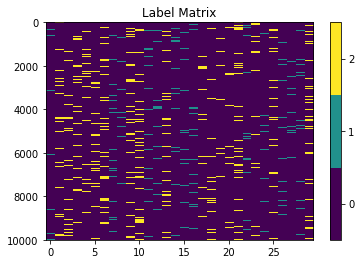

In [25]:
from metal.analysis import (
    view_label_matrix,
    view_overlaps,
    view_conflicts,
)

view_label_matrix(Ls[0])

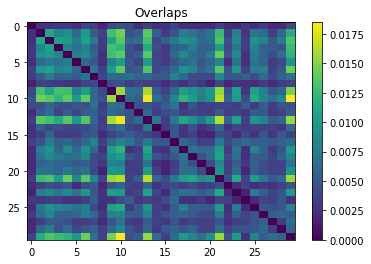

In [26]:
view_overlaps(Ls[0], normalize=True)

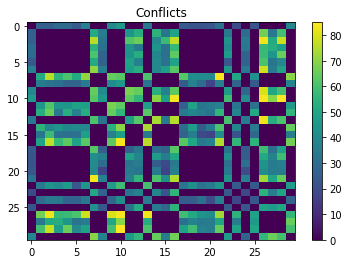

In [27]:
view_conflicts(Ls[0], normalize=False)